In [11]:
from all_functions import *
from sklearn.metrics import mean_absolute_percentage_error as mape
from aeon.visualisation import plot_series
import pywt
from scipy import signal
from pyts.image import MarkovTransitionField
from pyts.image import GramianAngularField
from pyts.image import RecurrencePlot
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV, HuberRegressor, Lasso, LassoLarsCV
from aeon.transformations.collection.convolution_based import (
    MiniRocket,
    Rocket,
    MiniRocketMultivariateVariable,
)
import warnings

def rolling_window_image2(series, window, representation, wavelet, level):
  data = []
  for i in range(len(series)-window):
    example = np.array(series[i:i+window+1])
    target = example[-1]

    features = np.delete(example, -1)
    features_norm = znorm(features)
    
    target_norm = znorm_by(target, features)

    rep_features1 = transform_series(features_norm, representation, "db4", 4)
    rep_features2 = transform_series(features_norm, representation, "db5", 4)

    reps = np.concatenate((rep_features1.flatten(), rep_features2.flatten()))
    feat_target = np.concatenate((reps, [target_norm]))
    data.append(feat_target)
  df = pd.DataFrame(data)
  return df

In [ ]:
import os
dirs = [
    '../datasets/venda/mensal/uf/gasolinac/',
    '../datasets/venda/mensal/uf/etanolhidratado/',
    '../datasets/venda/mensal/uf/glp/',
    '../datasets/venda/mensal/uf/oleodiesel/',
]
representation = "DWT"
horizon = 12
window = 36
for directory in dirs:
    for file in os.listdir(directory):
        transformations = ["normal", "log", "deseasonal"]
        chave = '_noresid'
        model_file = f'{representation}_ridge{chave}'
        results_file = f'./results/{model_file}'
        transformations = ["normal", "log", "deseasonal"]
        cols = ['train_range', 'test_range', 'UF', 'PRODUCT', 'MODEL', 'PARAMS', 'WINDOW', 'HORIZON', 'RMSE', 'MAPE', 'POCID', 'PBE','MCPM', 'MASE',
            'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'error_series',
            'Test Statistic', 'p-value', 'Lags Used', 'Observations Used', 'Critical Value (1%)', 'Critical Value (5%)', 'Critical Value (10%)', 'Stationary'
            ]
        if file.endswith('.csv'):
            derivado = file.split("_")[2].split(".")[0]
            uf = file.split("_")[1].upper()
            full_path = os.path.join(directory, file)
            
            series = read_series(full_path)
            train, test = train_test_stats(series, horizon)
            start_train = train.index.tolist()[0]
            final_train = train.index.tolist()[-1]

            start_test = test.index.tolist()[0]
            final_test = test.index.tolist()[-1]

            train_range = f"{start_train}_{final_train}"
            test_range = f"{start_test}_{final_test}"
            train_stl = train
            for tf in transformations:
                if 'noresid' in chave:
                    print_log('----------- SEM RESIDUO NA SERIE ---------')
                    transformer = STLTransformer(sp=12) 
                    stl = transformer.fit(train)
                    train_stl = stl.seasonal_ + stl.trend_
                train_tf = transform_regressors(train_stl, tf)

                data = rolling_window_image(pd.concat([train_tf, pd.Series([1,2,3,4,5,6,7,8,9,10,11,12], index=test.index)]), window, representation)
                data = data.dropna()

                X_train, X_test, y_train, _ = train_test_split(data, horizon)

                # minirocket = MiniRocket()  # by default, MiniRocket uses ~10_000 kernels
                # minirocket.fit(X_train)

                # rg = RandomForestRegressor()
                rg = RidgeCV(alphas=np.logspace(-3, 3, 10))
                rg.fit(X_train, y_train)
                # X_train_transform = minirocket.transform(X_train)
                # classifier = Ridge(alphas=np.logspace(-3, 3, 10))
                # classifier.fit(X_train_transform, y_train)

                # X_test_transform = minirocket.transform(X_test)

                predictions = recursive_multistep_forecasting(X_test, rg, horizon)
                preds = pd.Series(predictions, index=test.index)
                preds_real = reverse_regressors(train_stl, preds, format=tf)
                
                error_series = [a - b for a, b in zip(test.tolist(), preds_real)]
                y_baseline = series[-horizon*2:-horizon].values
                rmse_result = rmse(test, preds_real)
                mape_result = mape(test, preds_real)
                pocid_result = pocid(test, preds_real)
                pbe_result = pbe(test, preds_real)
                mcpm_result = mcpm(rmse_result, mape_result, pocid_result)
                mase_result = mase(test, preds_real, y_baseline)

                adfuller_test = analyze_stationarity(train_tf[1:])

                path_derivado = f'{results_file}/{derivado}/{tf}'
                os.makedirs(path_derivado, exist_ok=True)
                csv_path = f'{path_derivado}/transform_{uf}.csv'

                if not os.path.exists(csv_path):
                    pd.DataFrame(columns=cols).to_csv(csv_path, sep=';', index=False)

                df_temp = pd.DataFrame({'train_range': train_range, 'test_range': test_range , 'UF': uf, 'PRODUCT': derivado, 'MODEL': f'CWT-RF{chave}', 'PARAMS': '', 'WINDOW': window, 'HORIZON': horizon,  
                                        'RMSE': rmse_result, 'MAPE': mape_result, 'POCID': pocid_result, 'PBE': pbe_result,'MCPM': mcpm_result,  'MASE': mase_result,
                                        'P1': preds_real[0], 'P2': preds_real[1], 'P3': preds_real[2], 'P4': preds_real[3], 'P5': preds_real[4],
                                        'P6': preds_real[5], 'P7': preds_real[6], 'P8': preds_real[7], 'P9': preds_real[8], 'P10': preds_real[9],
                                        'P11': preds_real[10], 'P12': preds_real[11], 
                                        'error_series': [error_series],
                                        'Test Statistic': adfuller_test['Test Statistic'], 'p-value': adfuller_test['p-value'],
                                        'Lags Used': adfuller_test['Lags Used'],  'Observations Used': adfuller_test['Observations Used'], 'Critical Value (1%)': adfuller_test['Critical Value (1%)'],
                                        'Critical Value (5%)': adfuller_test['Critical Value (5%)'], 'Critical Value (10%)': adfuller_test['Critical Value (10%)'], 'Stationary': adfuller_test['Stationary']
                                        }, index=[0])
                # df_temp.to_csv(csv_path, sep=';', mode='a', header=False, index=False)

In [88]:
# pywt.wavelist()

In [21]:
estado = "SP"
derivado = "oleodiesel"
horizon = 12
window = 36
representation = "DWT"
transform = "deseasonal"
wavelet = "morl"
level = 2
series = read_series(f'../datasets/venda/mensal/uf/{derivado}/mensal_{estado.lower()}_{derivado}.csv')
train, test = train_test_stats(series, horizon)
train_tf = transform_regressors(train, transform)

data = rolling_window_image2(pd.concat([train_tf, pd.Series([0,0,0,0,0,0,0,0,0,0,0,0], index=test.index)]), window, representation, wavelet, level)
X_train, X_test, y_train, _ = train_test_split(data, horizon)
rg = RidgeCV(alphas=np.logspace(-3, 3, 10))
# rg = Ridge()
rg.fit(X_train, y_train)

predictions = recursive_multistep_forecasting(X_test, rg, horizon)
preds = pd.Series(predictions, index=test.index)
preds_deseasonal = reverse_regressors(train, preds, format=transform)
preds_deseasonal

timestamp
2023-03    1.070964e+06
2023-04    1.052687e+06
2023-05    1.094428e+06
2023-06    1.097929e+06
2023-07    1.139307e+06
2023-08    1.181094e+06
2023-09    1.128931e+06
2023-10    1.170076e+06
2023-11    1.121719e+06
2023-12    1.036728e+06
2024-01    9.765892e+05
2024-02    9.557794e+05
Freq: M, dtype: float64

In [22]:
wavelet = "db4"
level = 4
data = rolling_window_image(pd.concat([train_tf, pd.Series([0,0,0,0,0,0,0,0,0,0,0,0], index=test.index)]), window, representation, wavelet, level)
X_train, X_test, y_train, _ = train_test_split(data, horizon)
rg = RidgeCV(alphas=np.logspace(-3, 3, 10))
rg.fit(X_train, y_train)
    
predictions = recursive_multistep_forecasting(X_test, rg, horizon)
preds = pd.Series(predictions, index=test.index)
preds_morl = reverse_regressors(train, preds, format=transform)

In [23]:
wavelet = "db5"
level = 4
data = rolling_window_image(pd.concat([train_tf, pd.Series([0,0,0,0,0,0,0,0,0,0,0,0], index=test.index)]), window, representation, wavelet, level)
X_train, X_test, y_train, _ = train_test_split(data, horizon)
rg = RidgeCV(alphas=np.logspace(-3, 3, 10))
rg.fit(X_train, y_train)
    
predictions = recursive_multistep_forecasting(X_test, rg, horizon)
preds = pd.Series(predictions, index=test.index)
preds_mexh = reverse_regressors(train, preds, format=transform)

In [ ]:
data = rolling_window_image(pd.concat([train_tf, pd.Series([0,0,0,0,0,0,0,0,0,0,0,0], index=test.index)]), window, representation)
X_train, X_test, y_train, _ = train_test_split(data, horizon)

minirocket = Rocket(num_kernels=1000)  # by default, MiniRocket uses ~10_000 kernels
minirocket.fit(X_train)

X_train_transform = minirocket.transform(X_train)

# classifier = RidgeCV(alphas=np.logspace(-3, 3, 10))
classifier = RandomForestRegressor()
classifier.fit(pd.DataFrame(X_train_transform), y_train)

X_test_transform = minirocket.transform(X_test)

predictions = recursive_multistep_rocket(X_test, minirocket, classifier, horizon)
preds = pd.Series(predictions, index=test.index)
preds_rocket = reverse_regressors(train, preds, format=transform)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='m3'>)

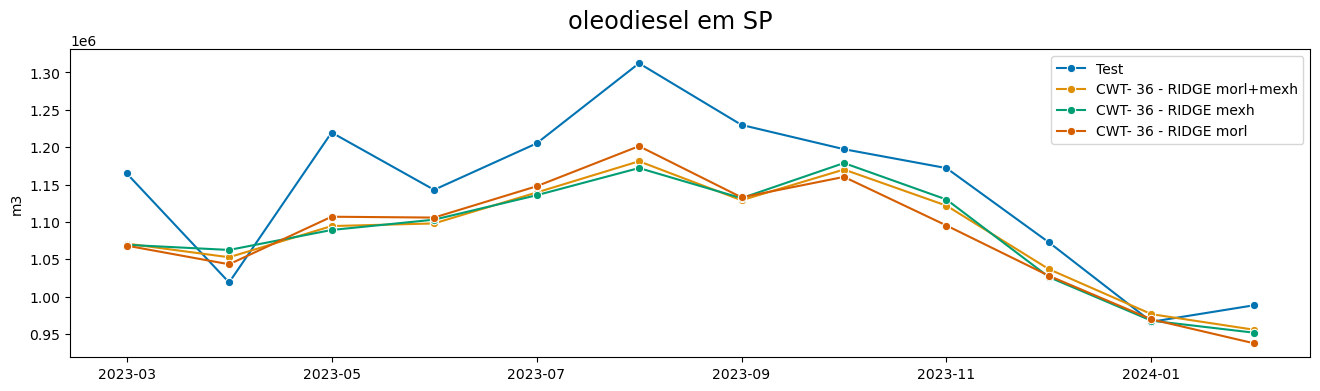

In [24]:
# plot_series(test, preds_deseasonal, preds_rf,preds_rocket, labels=["Test", "CWT- 36 - RIDGE","CWT- 36 - RF", "CWT - 36 - ROCKET - RIDGE"], title=f"{derivado} em {estado}")
plot_series(test,
             preds_deseasonal, 
            preds_mexh,
            preds_morl,
            labels=["Test", "CWT- 36 - RIDGE morl+mexh",
                "CWT- 36 - RIDGE mexh",
                "CWT- 36 - RIDGE morl"
                    ], 
                    title=f"{derivado} em {estado}")